Analyze Browsing History,  Recognize Ourselves
===

<img src="imgs/sqlite.png" width=90% />

In [1]:
import os
import sqlite3
import operator
from collections import OrderedDict
import matplotlib.pyplot as plt

%matplotlib inline

Convert data  into CSV
---
Sqlite is decoded as binary code; it can converted into csv format:

In [ ]:
from datetime import datetime, timedelta
import csv
#conn = sqlite3.connect('C:\Users\<USER NAME>\AppData\Local\Google\Chrome\User Data\Default\History')
conn = sqlite3.connect('History')
conn.text_factory = str
c = conn.cursor()

# writing binary requires the option, encoding='utf8'
filename='chrome_history.csv'
output_file = open(filename, 'w',encoding='utf8')
csv_writer = csv.writer(output_file)
headers = ('Title', 'Visit Count', 'Date (GMT)')
csv_writer.writerow(headers)
epoch = datetime(1601, 1, 1)
for row in (c.execute('select url, title, visit_count, last_visit_time from urls')):
    row = list(row)
    url_time = epoch + timedelta(microseconds=row[3])
    row[3] = url_time
    csv_writer.writerow(row)

In [15]:
# The data format
!head -n 5  chrome_history.csv

In [1]:
import pandas as pd
import seaborn as sns
from numpy import genfromtxt
import warnings
warnings.filterwarnings('ignore')

sns.set()

In [8]:
?pd.DataFrame.from_csv

In [9]:
#df = pd.DataFrame.from_csv('chrome_history.csv',index_col=0,parse_dates=[0],encoding="utf-8")
df = pd.DataFrame.from_csv('chrome_history.csv',index_col=None,encoding="utf-8")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136 entries, 0 to 135
Data columns (total 4 columns):
URL            136 non-null object
Title          105 non-null object
Visit Count    136 non-null int64
Date (GMT)     136 non-null object
dtypes: int64(1), object(3)
memory usage: 4.3+ KB


In [11]:
df.tail(10)

,URL,Title,Visit Count,Date (GMT)
126,http://127.0.0.1:8888/edit/Documents/2016/Andr...,GPSCoord-3.html (editing),1,2016-11-07 02:30:22.250694
127,http://127.0.0.1:8888/edit/Documents/2016/Andr...,GPSCoord-5-1.html (editing),1,2016-11-07 02:31:25.256371
128,http://127.0.0.1:8888/edit/Documents/2016/Andr...,GPSCoord-5-1.html,7,2016-11-07 02:46:14.580961
129,file:///Users/cch/Documents/2016/Android/googl...,NaN,1,2016-11-07 08:49:10.997982
130,http://www.tenlong.com.tw/,天瓏網路書店,1,2016-11-22 04:55:59.873200
131,https://www.tenlong.com.tw/,天瓏網路書店,2,2016-11-22 04:57:54.259416
132,https://www.tenlong.com.tw/events/274,天瓏網路書店,1,2016-11-22 04:56:27.681181
133,http://localhost:8888/notebooks/Documents/IPyt...,Jupyter Notebook,1,2016-11-23 11:07:44.851059
134,http://ge.cgu.edu.tw/files/13-1002-5325.php,人文藝術成員介紹 - 長庚大學 通識中心,1,2016-12-08 04:10:02.937801
135,file:///Users/cch/Desktop/cgee.html,人文藝術成員介紹 - 長庚大學 通識中心,1,2016-12-08 04:11:17.129225


In [2]:
def parse(url):
    try:
        parsed_url_components = url.split('//')
        sublevel_split = parsed_url_components[1].split('/', 1)
        domain = sublevel_split[0].replace("www.", "")
        return domain
    except IndexError:
        print("URL format error!")

In [12]:
def analyze(results,prompt="p"):
    #prompt = raw_input("[.] Type <c> to print or <p> to plot\n[>] ")
    if prompt == "c":
       for site, count in sites_count_sorted.items():
           print(site, count)
    else:
        plt.figure(figsize=(10,8))
        plt.bar(range(len(results)), results.values(), align='edge')
        plt.xticks(rotation=45)
        plt.xticks(range(len(results)), results.keys())

In [5]:
# File
#data_path = os.path.expanduser('~')+"\AppData\Local\Google\Chrome\User Data\Default"
#files = os.listdir(data_path)

#history_db = os.path.join(data_path, 'history')
history_db="History"

What the Sqlite DB stored
---
```shell
> sqlite3 History
SQLite version 3.13.0 2016-05-18 10:57:30
Enter ".help" for usage hints.
sqlite> .tables
downloads             meta                  urls                
downloads_url_chains  segment_usage         visit_source        
keyword_search_terms  segments              visits              
sqlite> .schema
...
CREATE TABLE urls(id INTEGER PRIMARY KEY,url LONGVARCHAR,title LONGVARCHAR,visit_count INTEGER DEFAULT 0 NOT NULL,typed_count INTEGER DEFAULT 0 NOT NULL,last_visit_time INTEGER NOT NULL,hidden INTEGER DEFAULT 0 NOT NULL,favicon_id INTEGER DEFAULT 0 NOT NULL);
...
sqlite> 
```

In [19]:
# Open Sqlite database
c = sqlite3.connect(history_db)
cursor = c.cursor()
# Select Data
select_statement = "SELECT urls.url, urls.visit_count FROM urls, visits WHERE urls.id = visits.url;"
cursor.execute(select_statement)

results = cursor.fetchall() #tuple

In [22]:
results[0:2]

([('https://www.google.com.tw/webhp?sourceid=chrome-instant&ion=1&espv=2&ie=UTF-8',
   9),
  ('https://www.google.com.tw/webhp?sourceid=chrome-instant&ion=1&espv=2&ie=UTF-8',
   9)],
 ('https://www.google.com.tw/webhp?sourceid=chrome-instant&ion=1&espv=2&ie=UTF-8#q=enigma',
  2))

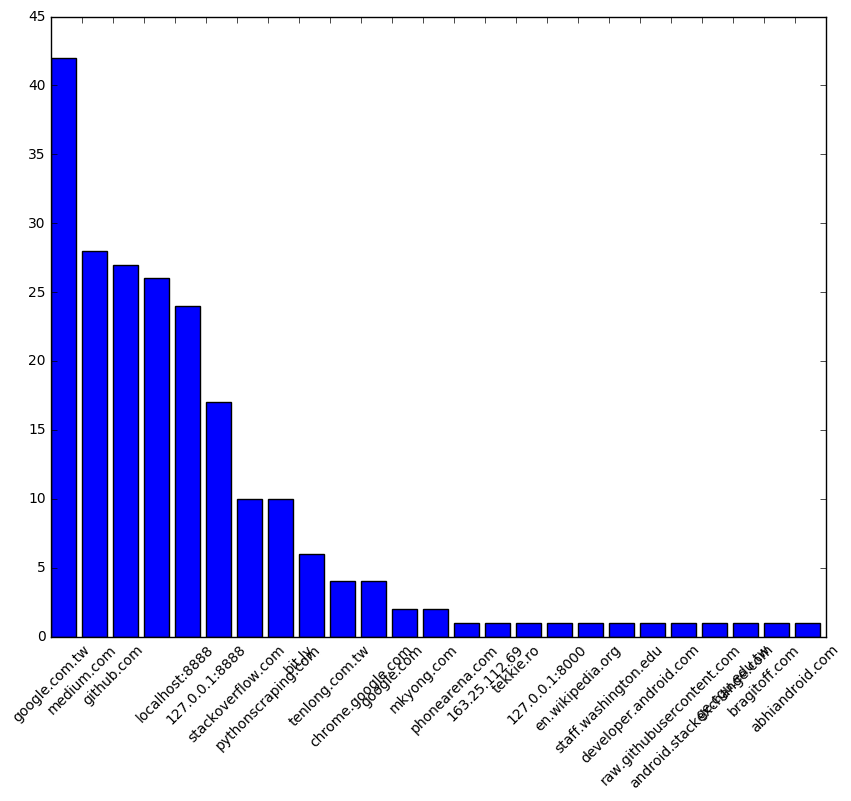

In [11]:
sites_count = {} #dict makes iterations easier :D

for url, count in results:
    url = parse(url)
    if url in sites_count:
       sites_count[url] += 1
    else:
       sites_count[url] = 1

sites_count_sorted = OrderedDict(sorted(sites_count.items(), key=operator.itemgetter(1), reverse=True))

analyze (sites_count_sorted)

Mac/IPhone
---
data could be found in `~/Library/Safari`.


```
> sqlite3 History.db

sqlite> .table
history_client_versions  history_tombstones       metadata               
history_items            history_visits         
sqlite> .schema
CREATE TABLE history_items (id INTEGER PRIMARY KEY AUTOINCREMENT,url TEXT NOT NULL UNIQUE,domain_expansion TEXT NULL,visit_count INTEGER NOT NULL,daily_visit_counts BLOB NOT NULL,weekly_visit_counts BLOB NULL,autocomplete_triggers BLOB NULL,should_recompute_derived_visit_counts INTEGER NOT NULL, visit_count_score INTEGER NOT NULL DEFAULT 0);
CREATE TABLE history_visits (id INTEGER PRIMARY KEY AUTOINCREMENT,history_item INTEGER NOT NULL REFERENCES history_items(id) ON DELETE CASCADE,visit_time REAL NOT NULL,title TEXT NULL,load_successful BOOLEAN NOT NULL DEFAULT 1,http_non_get BOOLEAN NOT NULL DEFAULT 0,synthesized BOOLEAN NOT NULL DEFAULT 0,redirect_source INTEGER NULL UNIQUE REFERENCES history_visits(id) ON DELETE CASCADE,redirect_destination INTEGER NULL UNIQUE REFERENCES history_visits(id) ON DELETE CASCADE,origin INTEGER NOT NULL DEFAULT 0,generation INTEGER NOT NULL DEFAULT 0, attributes INTEGER NOT NULL DEFAULT 0, score INTEGER NOT NULL DEFAULT 100);
...
sqlite> 

```

In [ ]:
conn = sqlite3.connect('History.db')
conn.text_factory = str

c = conn.cursor()
filename='safari_history.csv'
output_file = open(filename, 'w',encoding='utf8')
csv_writer = csv.writer(output_file)
headers = ('Title', 'Visit Count', 'Date (GMT)')
csv_writer.writerow(headers)
epoch = datetime(1601, 1, 1)
for row in (c.execute('select url, title, visit_count, last_visit_time from urls')):
    row = list(row)
    url_time = epoch + timedelta(microseconds=row[3])
    row[3] = url_time
    csv_writer.writerow(row)

In [ ]:
'History.db'history_db=
c = sqlite3.connect(history_db)
cursor = c.cursor()
# Select Data
select_statement = "SELECT urls.url, urls.visit_count FROM urls, visits WHERE urls.id = visits.url;"
cursor.execute(select_statement)

results = cursor.fetchall() #tuple

In [ ]:
import plistlib
pl = plistlib.readPlist("Downloads.plist")
pl["DownloadHistory"]